In [1]:
import pandas as pd
from ETL import ETL
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset/2012.csv')

In [3]:
df = ETL(df)

c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'FL_MON'] = df['FL_DATE'].apply(lambda x: x.month)
c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'FL_DAY'] = df['FL_DATE'].apply(lambda x: x.day)
c:\Users\dswal\Desktop\Data-Science-Project\ETL.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

# Clustering

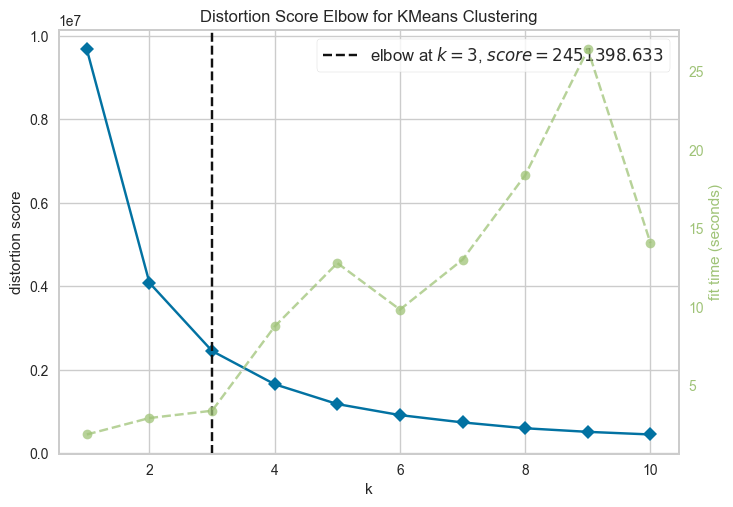

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selezioniamo le colonne di interesse e gestiamo eventuali valori nulli
data = df[['DEP_DELAY', 'ARR_DELAY']].fillna(0)

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Creazione del modello KMeans
model = KMeans(random_state=42)

# Utilizzo di KElbowVisualizer per determinare il numero ottimale di cluster
visualizer = KElbowVisualizer(model, k=(1, 11), metric='distortion', timings=True)

# Fit dei dati e visualizzazione del grafico
visualizer.fit(data_scaled)
visualizer.show()


In [7]:
# Gestire eventuali valori nulli
data.fillna(0, inplace=True)

# Standardizzazione dei dati per evitare che le variabili con valori più alti influenzino il clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(data_scaled)

C:\Users\dswal\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


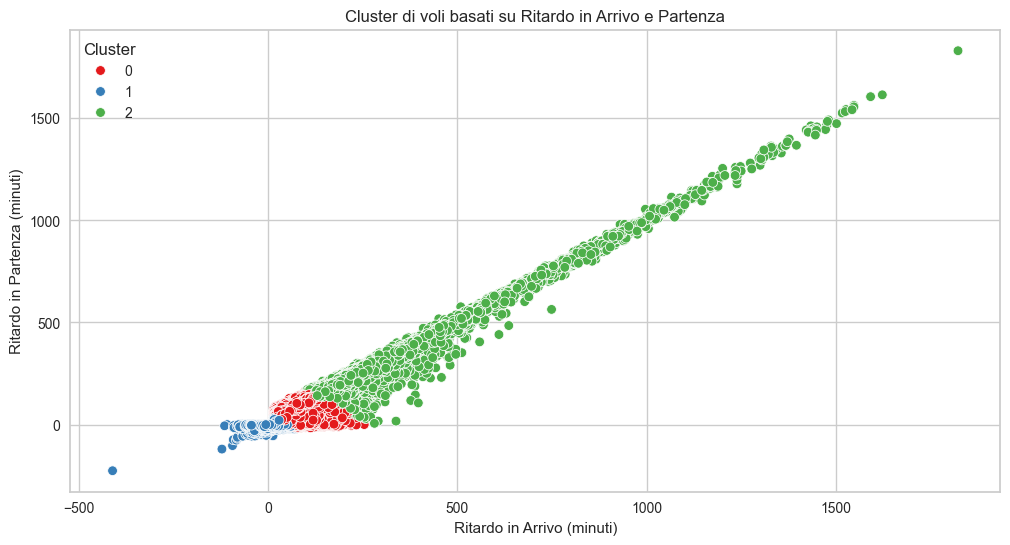

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ARR_DELAY', y='DEP_DELAY', hue='Cluster', data=df, palette='Set1')
plt.title('Cluster di voli basati su Ritardo in Arrivo e Partenza')
plt.xlabel('Ritardo in Arrivo (minuti)')
plt.ylabel('Ritardo in Partenza (minuti)')
plt.legend(title='Cluster')
plt.show()

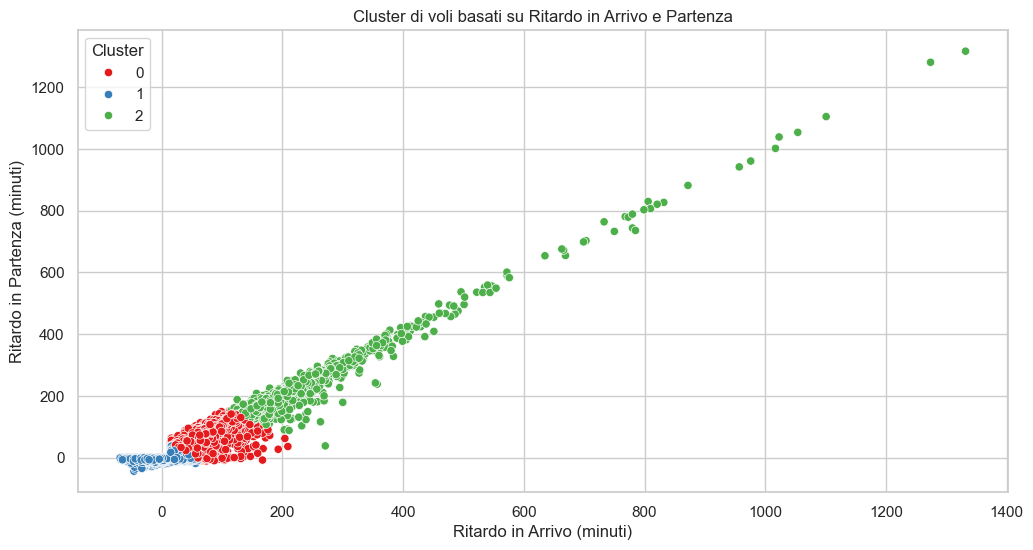

In [11]:
sample_df = df.sample(n=100000, random_state=42) 
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ARR_DELAY', y='DEP_DELAY', hue='Cluster', data=sample_df, palette='Set1')
plt.title('Cluster di voli basati su Ritardo in Arrivo e Partenza')
plt.xlabel('Ritardo in Arrivo (minuti)')
plt.ylabel('Ritardo in Partenza (minuti)')
plt.legend(title='Cluster')
plt.show()
